In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import os, glob
import torch

from models.main import build_network
from preprocess import get_data

In [2]:
class Args:
    model='ae'
    r='./experiments'
    lr=5e-3
    z_dim=64
    in_dim=152
    data_pth='../data'
    batch_size=128
    outlier='AGN'
    hierClass='Stochastic'
    fold=0

args = Args()
job_name = '{}_{}_{}_lr{}_ld{}_fold{}'.format(args.model, args.hierClass, args.outlier, args.lr, args.z_dim, args.fold)
args.directory = os.path.join(args.r, job_name)

### Learning curves

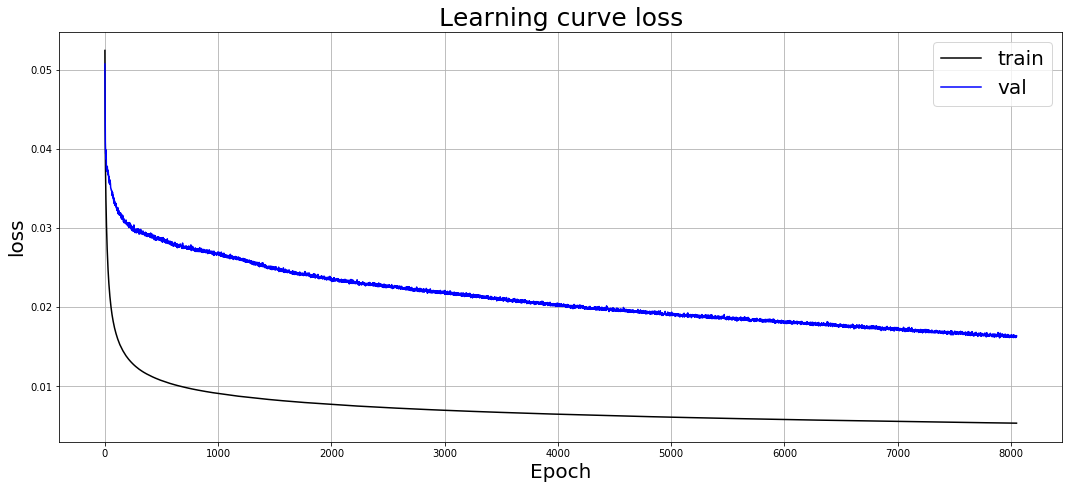

In [3]:
from utils.plots import plot_event

event_pth = 'event*'
event = glob.glob(os.path.join(args.directory, event_pth))
plot_event(event)

### Analyzing latent space.

In [4]:
# train, val, test
_, _, dataloader = get_data(args)

Blazar
CV/Nova
QSO
YSO
Blazar
CV/Nova
QSO
YSO
AGN
Blazar
CV/Nova
DSCT
E
LPV
Periodic-Other
QSO
RRL
SLSN
SNII
YSO


In [5]:
model_pth = os.path.join(args.directory, 'trained_parameters.pth')
state_dict = torch.load(model_pth)
model = build_network(args)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
zs = []
xrec = []
xreal = []
lbls_out = []
lbls_class = []
for _, x, lbl_class, lbl_out in dataloader:
    with torch.no_grad():
        model.eval()
        x = x.float()

        z, x_hat = model(x)
        zs.append(z)
        xrec.append(x_hat)
        xreal.append(x)
        lbls_out.append(lbl_out)
        lbls_class.append(lbl_class)
zs = torch.cat(zs).numpy()
xrec = torch.cat(xrec).numpy()
xreal = torch.cat(xreal).numpy()
lbls_out = torch.cat(lbls_out).numpy()
lbls_class = torch.cat(lbls_class).numpy()

In [7]:
from sklearn.manifold import TSNE
import numpy as np 

x_embedded = TSNE(n_components=2).fit_transform(zs)

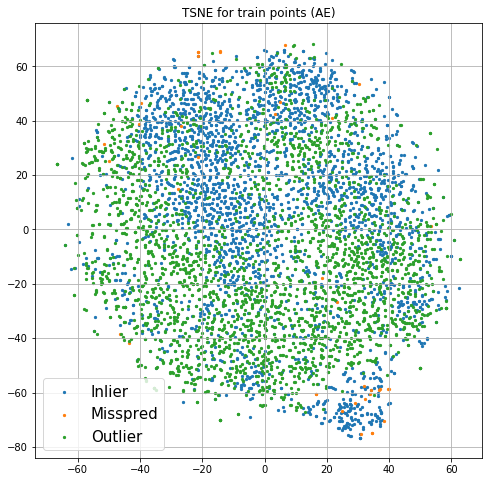

In [8]:
dict_classes = {0: 'Inlier',
                1: 'Misspred',
                2: 'Outlier',
    
}

plt.figure(figsize=(8,8))
plt.title('TSNE for train points (AE)')
cmap = plt.get_cmap('jet', 4)
for key in range(len(np.unique(lbls_out))):
    plt.scatter(x_embedded[:, 0][lbls_out==key], x_embedded[:, 1][lbls_out==key], 
                s=20, alpha=1, marker='.', label=dict_classes[key])
plt.legend(fontsize=15)
plt.grid(True)

## Analyzing reconstructions.

In [9]:
feature_list_pth='../data_raw/features_RF_model.pkl'
feature_list = pd.read_pickle(feature_list_pth)
feature_list

# Some important features
important_features = [
'W1-W2',
'sgscore1',
'positive_fraction_2',
'positive_fraction_1',
'SPM_tau_rise_1',
'LinearTrend_2', 
'SPM_chi_1', 
'g-W2', 
'g-W3', 
'n_non_det_after_fid_2',
'W2-W3',
'SPM_beta_1',
'SPM_tau_rise_2',
'SPM_A_2',
'IAR_phi_1',
'IAR_phi_2',
]

In [31]:
def update(handle, orig):
    handle.update_from(orig)
    handle.set_alpha(1)

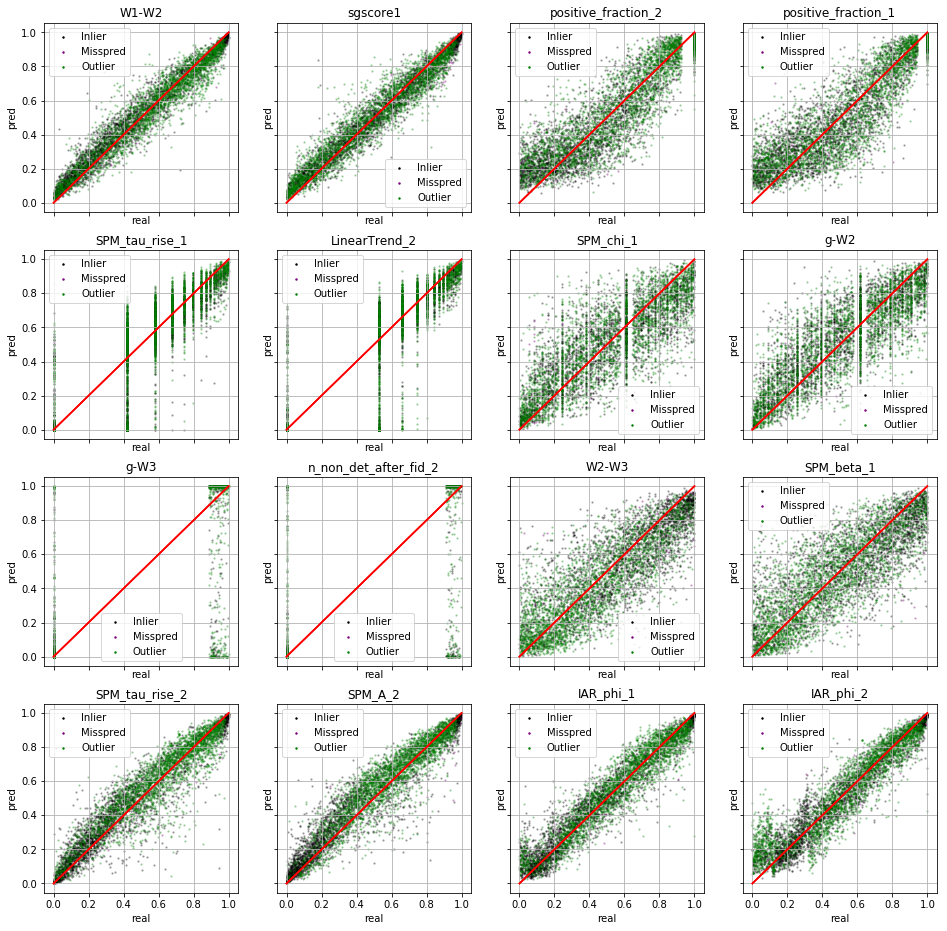

In [33]:
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D

f, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,16), sharey=True, sharex=True)

colors = {0: 'k', #inlier
          1: 'purple', #outlier
          2: 'green', #wc
}

ident = [0.0, 1.0]
for i, feature in enumerate(important_features):
    for key in range(len(np.unique(lbls_out))):
        ix = important_features.index(feature)
        ax[i//4, i%4].set_title(feature)
        ax[i//4, i%4].scatter(xreal[:,ix][(lbls_out==key)], xrec[:,ix][(lbls_out==key)], 
                              label=dict_classes[key], s=2, alpha=0.25, c=colors[key])
        ax[i//4, i%4].plot(ident, ident, c='r')
        ax[i//4, i%4].set_xlabel('real')
        ax[i//4, i%4].set_ylabel('pred')
        ax[i//4, i%4].grid()
        ax[i//4, i%4].legend(loc='best', handler_map={PathCollection : HandlerPathCollection(update_func= update),
                             plt.Line2D : HandlerLine2D(update_func = update)})
plt.show()

### Report metrics

In [ ]:
from sklearn.metrics import auc


def auroc(in_scores, out_scores):
    scores = np.concatenate((in_scores, out_scores), axis=0)
    start = np.min(scores)
    end = np.max(scores)   
    gap = (end- start)/100000

    aurocBase = 0.0
    fprTemp = 1.0
    tprs = []
    fprs = []
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(out_scores > delta)) / np.float(len(out_scores))
        fpr = np.sum(np.sum(in_scores <= delta)) / np.float(len(in_scores))
        tprs.append(tpr)
        fprs.append(fpr)
    return auc(fprs, tprs)


In [54]:
from sklearn.metrics import auc

scores = np.sum((xrec - xreal)**2, axis=1)
start = np.min(scores)
end = np.max(scores)   
gap = (end - start)/100000

aurocBase = 0.0
fprTemp = 1.0
tprs = []
fprs = []

in_scores = scores[lbls_out==0]
out_scores = scores[(lbls_out==1) | (lbls_out==2)]

for delta in np.arange(start, end, gap):
    tpr = np.sum(np.sum(out_scores > delta)) / len(scores)
    fpr = np.sum(np.sum(in_scores > delta)) / len(in_scores)
    tprs.append(tpr)
    fprs.append(fpr)
auc(fprs, tprs)

0.3354150141953778

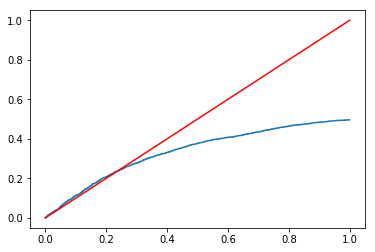

In [56]:
ident=[0.0, 1.0]
plt.plot(fprs, tprs)
plt.plot(ident, ident, c='r')

In [53]:
in_scores, out_scores

(array([2.4071212, 1.9810491, 2.8793721, ..., 2.0753021, 1.4544227,
        2.0532231], dtype=float32),
 array([4.8408785, 2.2426128, 2.5948334, ..., 1.9206324, 4.2697387,
        1.8143022], dtype=float32))

In [ ]:
def aupr(in_scores, out_scores):
    scores = np.concatenate((in_scores, out_scores), axis=0)
    start = np.min(scores)
    end = np.max(scores)   
    gap = (end- start)/100000
    
    precisions = []
    recalls = []
    for delta in np.arange(start, end, gap):
        tp = np.sum(np.sum(out_scores <= delta)) #/ np.float(len(out_scores))
        fp = np.sum(np.sum(in_scores <= delta)) #/ np.float(len(in_scores))
        if tp + fp == 0: continue
        precision = tp / (tp + fp)
        recall = tp / np.float(len(out_scores))
        precisions.append(precision)
        recalls.append(recall)
    return auc(recalls, precisions)